In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import hmp
from itertools import cycle
import bambi as bmb 
import pandas as pd
import arviz as az
from itertools import product
from os import listdir
import seaborn as sns
import scipy.optimize as opt
import re 


def fit_or_load(filename, path, model):
    if filename not in listdir(path):
        fit = model.fit(inference_method='nuts_numpyro')
        fit.to_netcdf(path+'/'+filename)
    else:
        fit = az.from_netcdf(path+'/'+filename)
    return fit

# Distribution simulations

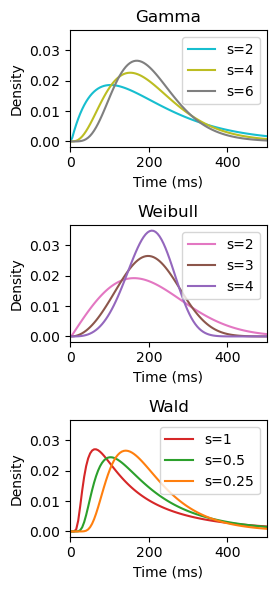

In [2]:
fig, ax = plt.subplots(3,1, sharex=False, sharey=True, figsize=(3,6))
# plt.suptitle('Effect of different shape parameters for a given mean of 200')
distributions = [[['gamma',2],['gamma',4],['gamma',6]],
                 [['weibull',2],['weibull',3],['weibull',4]],
                 [['wald',1],['wald',.5],['wald',.25]],
                 ]

colors = iter([plt.cm.tab10(i) for i in range(10)][::-1])
j,k = 0,0
for family in distributions:
    for distribution in family:
        color = next(colors)
        hmp.visu.plot_expected_distribution(distribution[0], 200, distribution[1], color=color, location=0, xmax=500, num=100, label=f's={distribution[1]}', ax=ax[j])
    ax[j].legend()#bbox_to_anchor=(1,1))
    ax[j].set_title(family[0][0].capitalize())
    ax[j].set_xlim(0,500)
    ax[j].set_xlabel('Time (ms)')
    ax[j].set_ylabel('Density')
    j += 1
plt.tight_layout()
plt.savefig('../../plots/distribution_illustration.png',dpi=300,transparent=True)
plt.show()

## Collecting and concatenating results from cluster

In [3]:
from os import listdir

results = []
i = 0 
path = 'results_app-2/'
for file in listdir(path):
    if 'results' in file:
        r_i = xr.load_dataset(path+file, engine='netcdf4')
        r_i['seed'] = r_i.seed
        results.append(r_i)
        i += 1
results = xr.concat(results, dim='iteration')
results['n_hit'] = results.hit.count('event')
results['PPV'] = (results['n_hit']) / results.test_n_events
results['TPR'] = (results['n_hit']) / results.n_events
results['recovered_event'] = ~(results.recov_mags.count(['component']) == 0 )
results['rts'] = results.true_trial_times.sum('stage')*10
print(f'{len(results.where(np.isnan(results.TPR), drop=True).iteration)} simulations are Nan')
results = results.dropna(dim="iteration", how="any", subset=['TPR'])
gen = np.char.add(results['gen_d'].values, results['gen_shape'].values.astype('<U7'))
gen = np.char.strip(gen, '.0')
results = results.assign_coords({'gen':('all_combination', gen)})
test = np.char.add(results['test_d'].values, results['test_shape'].values.astype('<U7'))
test = np.char.strip(test, '.0')
results = results.assign_coords({'test':('all_combination', test)})
results = results.assign_coords({'gen':('all_combination', [' '.join(re.split('(\d.?\d?\d?)',x)[:-1]).capitalize() for x in results.coords['gen'].values])})
results = results.assign_coords({'test':('all_combination', [' '.join(re.split('(\d.?\d?\d?)',x)[:-1]).capitalize() for x in results.coords['test'].values])})
results

0 simulations are Nan


<xarray.Dataset> Size: 305MB
Dimensions:           (iteration: 500, stage: 4, event: 3, all_combination: 81,
                       trial: 100, component: 5)
Coordinates:
    gen_d             (all_combination) <U7 2kB 'gamma' 'gamma' ... 'wald'
    gen_shape         (all_combination) float64 648B 2.0 2.0 2.0 ... 1.0 1.0 1.0
    test_d            (all_combination) <U7 2kB 'gamma' 'gamma' ... 'wald'
    test_shape        (all_combination) float64 648B 2.0 3.0 4.0 ... 0.5 1.0
    gen               (all_combination) <U9 3kB 'Gamma 2' 'Gamma 2' ... 'Wald 1'
    test              (all_combination) <U9 3kB 'Gamma 2' 'Gamma 3' ... 'Wald 1'
Dimensions without coordinates: iteration, stage, event, all_combination,
                                trial, component
Data variables: (12/17)
    means             (iteration, stage) float64 16kB 426.0 247.3 ... 235.2
    names             (iteration, event) <U19 114kB 'postcentral-lh' ... 'inf...
    test_n_events     (iteration, all_combination) float64 324kB 3.0 3.0 ... 3.0
    loglikelihood     (iteration, all_combination) float64 324kB 1.026e+03 .....
    time              (iteration, all_combination) float64 324kB 1.645 ... 3.051
    hit               (iteration, all_combination, event) float64 972kB 0.0 ....
    ...                ...
    seed              (iteration) int64 4kB 125 414 347 137 ... 271 172 490 395
    n_hit             (iteration, all_combination) int64 324kB 3 3 3 3 ... 3 3 3
    PPV               (iteration, all_combination) float64 324kB 1.0 1.0 ... 1.0
    TPR               (iteration, all_combination) float64 324kB 1.0 1.0 ... 1.0
    recovered_event   (iteration, all_combination, event) bool 122kB True ......
    rts               (iteration, all_combination, trial) float64 32MB 630.0 ...
Attributes:
    amplitude:    1e-07
    n_events:     3
    sfreq:        100
    n_comp:       5
    event_width:  50
    n_trials:     100
    seed:         125

## Inspecting pair generated/expected distribution

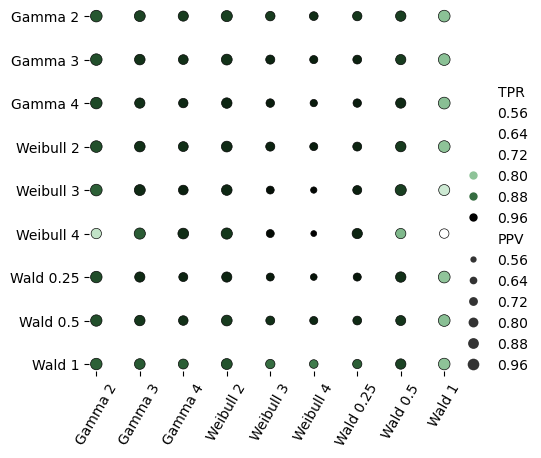

In [4]:
recov_hit = results.groupby('all_combination').mean(('trial','component','stage','event')).mean('iteration').to_dataframe()

# recov_hit = recov_hit.sort_values(by='gen')
# recov_hit = recov_hit.sort_values(by='test')
recov_hit.reset_index(drop=True, inplace=True)
# Draw each cell as a scatter point with varying size and color
g = sns.relplot(
    data=recov_hit,
    x="gen", y="test", hue="TPR", size='PPV',# hue_norm=(0.6,.8),
    palette=sns.cubehelix_palette(start=5, rot=0, dark=0, light=2, as_cmap=True), 
    height=5, legend='brief', edgecolor='k')

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)

for label in g.ax.get_xticklabels():
    label.set_rotation(60)
plt.savefig('../../plots/distribution_matrix.png',dpi=300,transparent=True,bbox_inches='tight')
plt.show()

# Modelling the TPR

In [5]:
n_events_df_tpr = results.groupby('all_combination').mean(('trial','component','stage','event')).to_dataframe().reset_index()
# n_events_df_tpr = n_events_df_tpr[n_events_df_tpr.event == 0]
n_events_df_tpr = n_events_df_tpr[n_events_df_tpr['rts']>0]#simulation that went wrong, most of the time Wald 1 has too much prob mass in very late durations
n_events_df_tpr['n_events'] = results.n_events
n_events_df_tpr['rts']  = n_events_df_tpr['rts'] /1000
n_events_df_tpr['rts'] = n_events_df_tpr.rts - n_events_df_tpr.rts.mean()


tpr_model = bmb.Model("p(n_hit, n_events) ~ rts * test ", n_events_df_tpr, family="binomial")
tpr_fit = fit_or_load('tpr_model_dist.nc', 'bambi_fits', tpr_model)


### Table

In [6]:
tpr_fit

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [7]:
az.summary(tpr_fit, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.452,0.033,2.391,2.520,0.001,0.001,1019.0,1901.0,1.01
rts,1.613,0.113,1.393,1.834,0.004,0.003,935.0,1556.0,1.01
test[Gamma 3],0.173,0.049,0.078,0.270,0.001,0.001,1874.0,2578.0,1.01
test[Gamma 4],0.271,0.050,0.174,0.372,0.001,0.001,1901.0,2618.0,1.00
test[Wald 0.25],0.302,0.052,0.200,0.399,0.001,0.001,1765.0,2733.0,1.01
test[Wald 0.5],0.119,0.048,0.017,0.209,0.001,0.001,1446.0,2464.0,1.01
test[Wald 1],-0.310,0.044,-0.396,-0.225,0.001,0.001,1523.0,2538.0,1.01
test[Weibull 2],0.188,0.049,0.093,0.287,0.001,0.001,1654.0,2648.0,1.01
test[Weibull 3],0.225,0.050,0.129,0.325,0.001,0.001,1590.0,2415.0,1.01
test[Weibull 4],-0.550,0.042,-0.634,-0.470,0.001,0.001,1240.0,2282.0,1.01


### Generating predictions for plotting

In [8]:
n_events_df_tpr['n_events'] = results.n_events
rts_tpr = np.linspace(n_events_df_tpr.rts.min(), n_events_df_tpr.rts.max(), num=100)
test_all_tpr = np.sort(n_events_df_tpr.test.unique())

new_data_tpr = pd.DataFrame({
    "test": np.tile(test_all_tpr, len(rts_tpr)),
    "rts": np.repeat(rts_tpr, len(test_all_tpr)),
})

tpr_model.predict(tpr_fit, data=new_data_tpr)
tpr_posterior = az.extract(tpr_fit, num_samples=1000)['p(n_hit, n_events)_mean']

# Modelling the positive predictive value

In [9]:
n_events_df_ppv = results.groupby('all_combination').mean(('trial','component','stage','event')).to_dataframe().reset_index()
# n_events_df_ppv = n_events_df_ppv[n_events_df_ppv.event == 0]
n_events_df_ppv = n_events_df_ppv[n_events_df_ppv['rts']>0]#simulation that went wrong, most of the time Wald 1 has too much prob mass in very late durations
n_events_df_ppv['n_events'] = results.n_events.astype('str')
n_events_df_ppv['rts']  = n_events_df_ppv['rts']/1000
n_events_df_ppv['rts'] = n_events_df_ppv.rts - n_events_df_ppv.rts.mean()


ppv_model = bmb.Model("p(n_hit, test_n_events) ~ rts * test ", n_events_df_ppv, family="binomial", dropna=True)
ppv_fit = fit_or_load('ppv_model_dist.nc', 'bambi_fits', ppv_model)


### Table

In [10]:
az.summary(ppv_fit, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.566,0.022,1.524,1.609,0.001,0.001,957.0,1688.0,1.0
rts,-0.724,0.080,-0.882,-0.571,0.003,0.002,797.0,1274.0,1.0
test[Gamma 3],-0.200,0.030,-0.260,-0.142,0.001,0.001,1575.0,2565.0,1.0
test[Gamma 4],-0.371,0.029,-0.429,-0.317,0.001,0.001,1427.0,2609.0,1.0
test[Wald 0.25],-0.498,0.028,-0.553,-0.444,0.001,0.001,1399.0,2430.0,1.0
test[Wald 0.5],-0.265,0.029,-0.325,-0.212,0.001,0.001,1467.0,2218.0,1.0
test[Wald 1],-0.072,0.031,-0.131,-0.009,0.001,0.001,1432.0,2220.0,1.0
test[Weibull 2],-0.163,0.030,-0.218,-0.100,0.001,0.001,1422.0,2350.0,1.0
test[Weibull 3],-0.382,0.029,-0.440,-0.327,0.001,0.001,1384.0,2182.0,1.0
test[Weibull 4],-0.428,0.029,-0.489,-0.374,0.001,0.001,1553.0,2581.0,1.0


### Generating predictions for plotting

In [11]:
n_events_df_ppv['n_events'] = results.n_events
rts_ppv = np.linspace(n_events_df_ppv.rts.min(), n_events_df_ppv.rts.max(), num=100)
test_all_ppv = np.sort(n_events_df_ppv.test.unique())

new_data_ppv = pd.DataFrame({
    "test": np.tile(test_all_ppv, len(rts_ppv)),
    "rts": np.repeat(rts_ppv, len(test_all_ppv)),
})

ppv_model.predict(ppv_fit, data=new_data_ppv)
ppv_posterior = az.extract(ppv_fit, num_samples=1000)['p(n_hit, test_n_events)_mean']

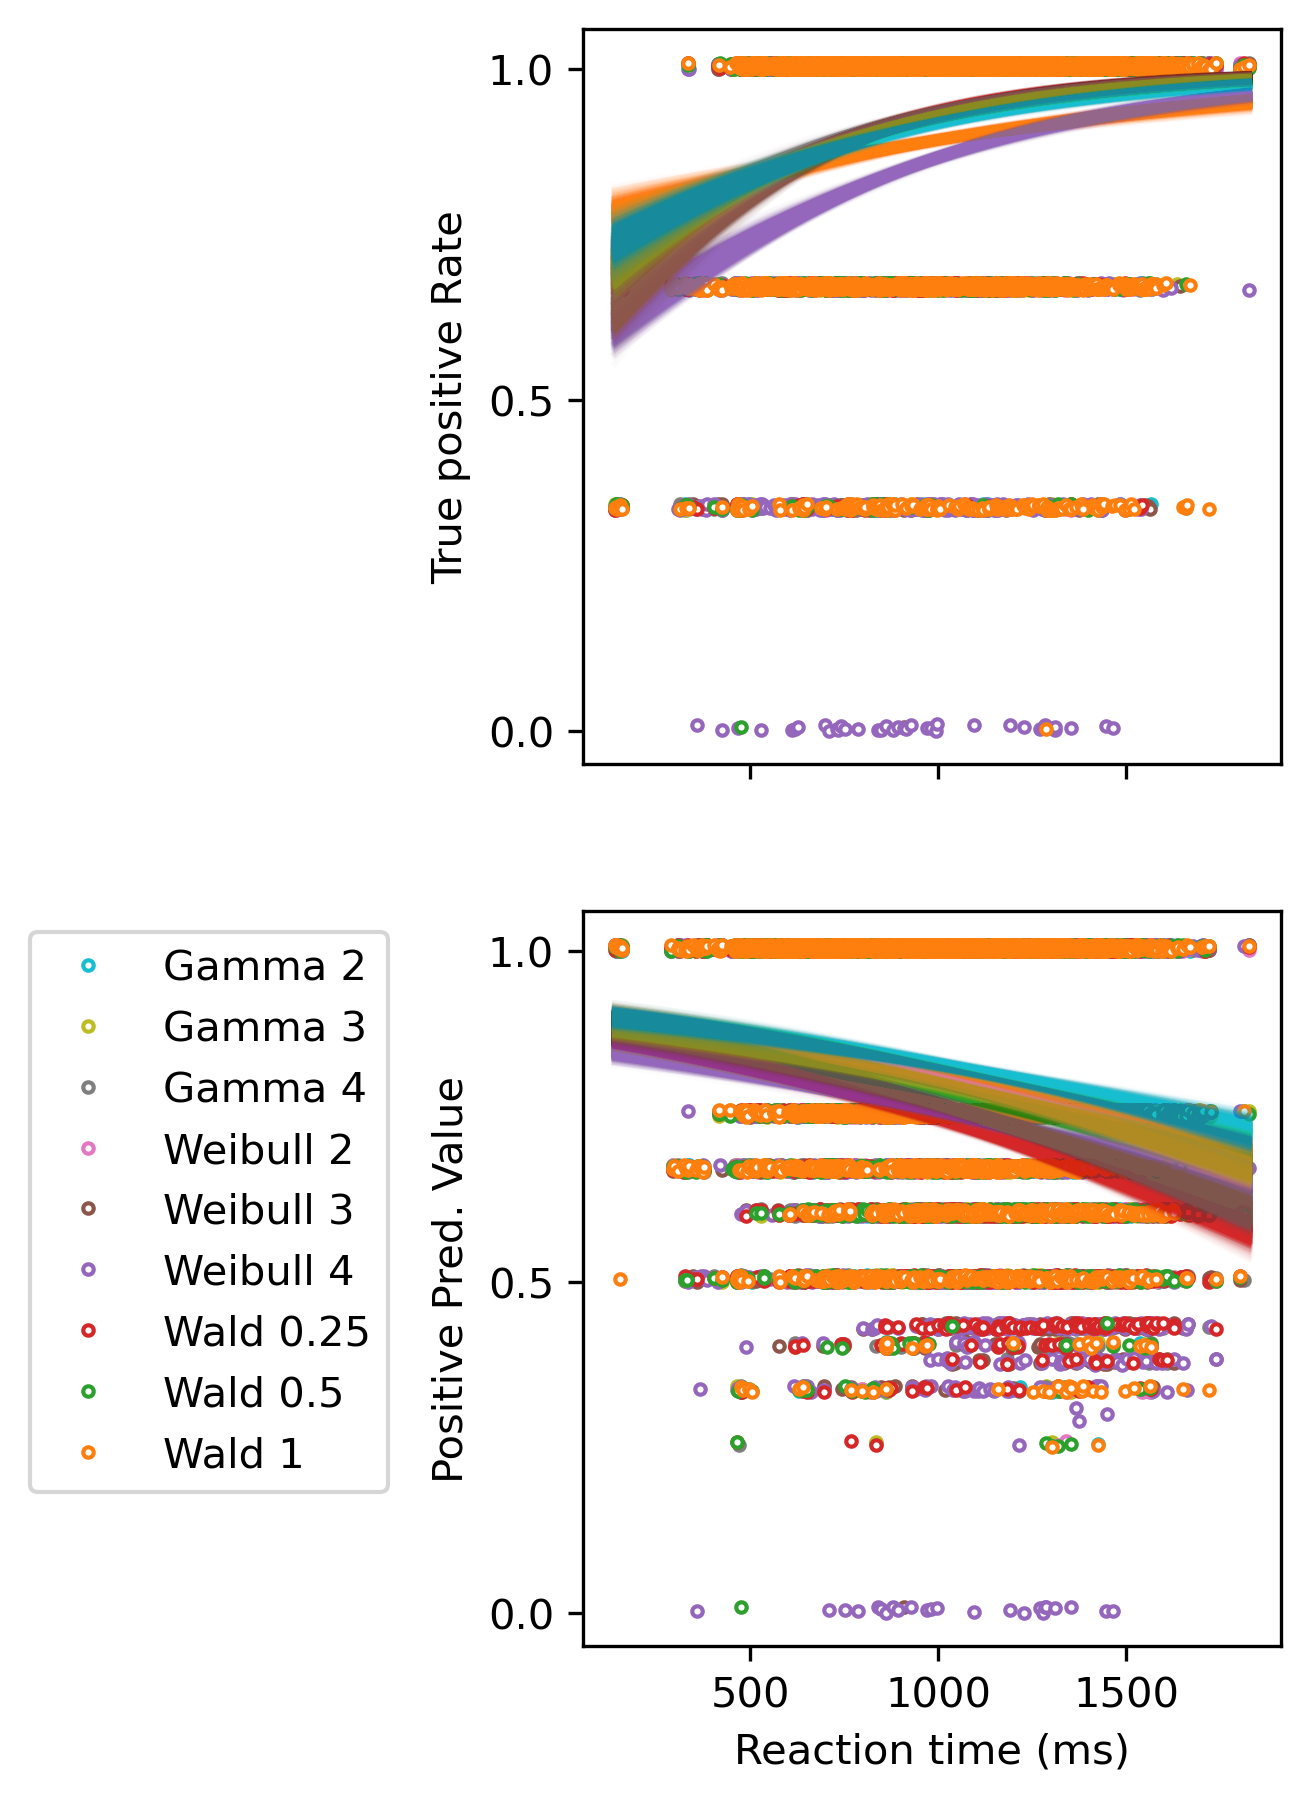

In [18]:
fig, ax = plt.subplots(2,1, dpi=300, figsize=(3,7), sharey=True, sharex=True)
colors = ['royalblue','darkgreen','indianred','goldenrod', 'pink', 'black']
mean_to_add = results.groupby('all_combination').mean(('trial','component','event','stage')).to_dataframe().reset_index().rts.mean()/1000#Rescaling predictor
colors = iter([plt.cm.tab10(i) for i in range(10)][::-1])

for i,test in enumerate(n_events_df_tpr.test.unique()):
    idx = new_data_tpr.index[(new_data_tpr["test"] == test)].tolist()
    c = next(colors)
    ax[0].plot((rts_tpr+mean_to_add)*1000, tpr_posterior[idx], alpha=0.02, color=c, zorder=10-i)
    subset = n_events_df_tpr[(n_events_df_tpr.test == test)].sort_values(by='rts')
    x = subset.rts
    y = subset.TPR
    ax[0].plot((x+mean_to_add)*1000, y+np.random.uniform(0, 1e-2, len(x)), '.', color=c, alpha=1, mfc='w', ms=5)
    y = subset.PPV
    ax[1].plot((rts_ppv+mean_to_add)*1000, ppv_posterior[idx], alpha=0.02, color=c, zorder=10-i)
    ax[1].plot((x+mean_to_add)*1000,  y+np.random.uniform(0, 1e-2, len(x)), '.', color=c, label=test,alpha=1, mfc='w', ms=5)

ax[0].set_ylabel('True positive Rate')
ax[0].set_yticks([0,.5,1])
ax[1].set_ylabel('Positive Pred. Value')
ax[1].set_yticks([0,.5,1])
ax[1].set_xlabel('Reaction time (ms)')
ax[1].legend(bbox_to_anchor=(-.25,1))
plt.savefig('../../plots/tprppv_distributions_alpha1.png',dpi=300,transparent=True,bbox_inches='tight')